<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Time_of_Flight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time of Flight**
---
Welcome to Particle Identification Playground! This activity is designed to introduce you to time of flight (TOF) detectors, and how they are used to identify particles.
**Before attempting this notebook, complete all of the activities in the Getting Started section.**

**After completing this notebook, you will be able to:**
*   Explain how time of flight can be used with momentum to calculate invariant mass
*   Demonstrate the separation power of TOF analysis using ROOT’s TH2D class
*   Classify different charged particles based on their TOF at fixed momentum

In [ ]:
#@title Run this cell before starting. This may take a few minutes to run.
!wget -q https://github.com/MohamedElashri/ROOT/releases/download/ubuntu/root_v6.28.04_Ubuntu_20.04.zip
!unzip -o -qq /content/root_v6.28.04_Ubuntu_20.04.zip
!apt-get -qq install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion &> /dev/null 2>&1
!rm -f root_v6.28.04_Ubuntu_20.04.zip
!wget -q http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb &> /dev/null 2>&1
!rm -f libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!wget -q -O TOF_hits.hdf5 https://github.com/duberii/pid-playground/raw/main/data/TOF_hits.hdf5
!wget -q -O BCal_TOF_hits.hdf5 https://github.com/duberii/pid-playground/raw/main/data/BCal_TOF_hits.hdf5
import sys
sys.path.append("/content/root_build/")
sys.path.append("/content/root_build/bin/")
sys.path.append("/content/root_build/include/")
sys.path.append("/content/root_build/lib/")
import ctypes
ctypes.cdll.LoadLibrary('/content/root_build/lib//libCore.so')
ctypes.cdll.LoadLibrary('/content/root_build/lib//libThread.so')
ctypes.cdll.LoadLibrary('/content/root_build/lib//libTreePlayer.so')
import pandas
from ROOT import *
import pandas as pd
import numpy as np
import plotly.express as pxp
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive, fixed, widgets, HBox, VBox, Layout
from PIL import Image
import plotly as ply
import plotly.graph_objects as go
def pdg_to_name(num):
  if int(num) == 2212:
    return "Proton"
  elif int(num) == 321:
    return "K+"
  elif int(num) == 211:
    return "Pi+"
  elif int(num) == 13:
    return "Muon"
  elif int(num)==11:
    return "Electron"
  elif int(num) == -2212:
    return "AntiProton"
  elif int(num) == -321:
    return "K-"
  elif int(num) == -211:
    return "Pi-"
  elif int(num) == -13:
    return "AntiMuon"
  elif int(num)==-11:
    return "Positron"
from google.colab import output
output.enable_custom_widget_manager()
TOF_hits = pd.read_hdf("TOF_hits.hdf5")
TOF_hits['ptype']= TOF_hits['ptype'].map(pdg_to_name)
BCal_TOF_hits = pd.read_hdf("BCal_TOF_hits.hdf5")
BCal_TOF_hits['ptype']= BCal_TOF_hits['ptype'].map(pdg_to_name)

Welcome to JupyROOT 6.28/04


---
##**What is Time of Flight?**
---
**Time of flight**, or TOF for short, refers to the time it takes for a particle to travel between two detectors. In essence, a TOF detector functions like a stopwatch. We have a starting detector, which starts the stopwatch as a particle passes through it, and a stopping detector, which stops the stopwatch when the particle passes through it. If we know the distance that the particle travelled between the two detectors (the **path length**), we can calculate the velocity by calculating the distance over time.

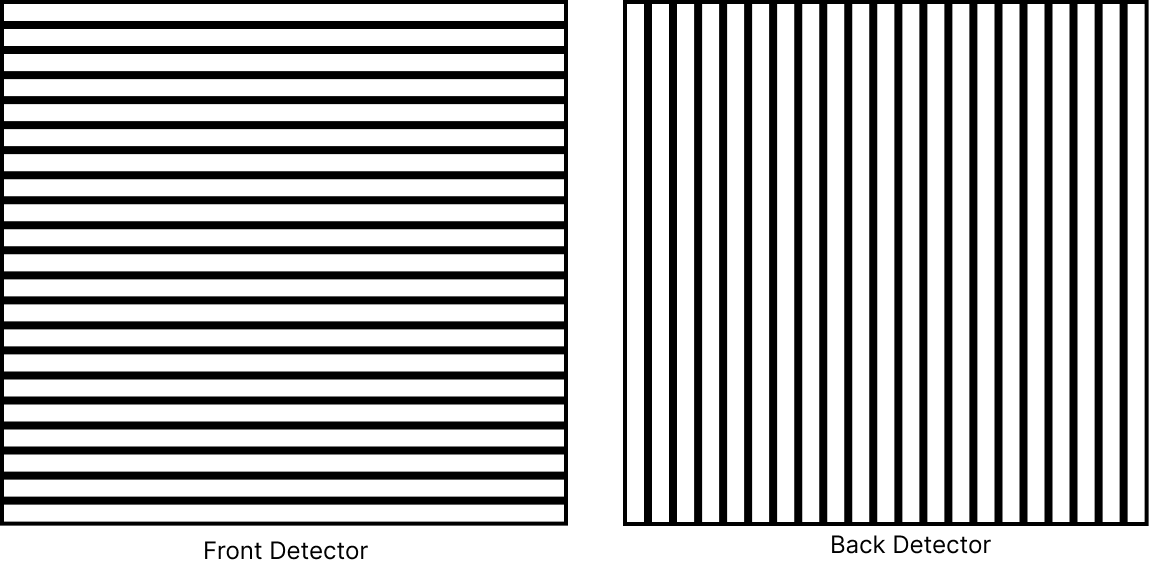](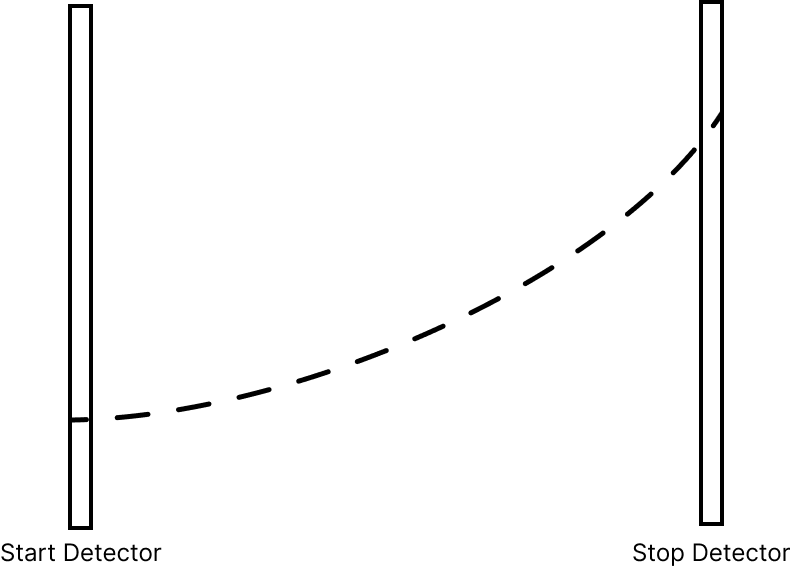)

Although a start detector is essential in theory, modern particle detectors almost never have a designated start detector. This is because modern detectors provide enough information for us to figure out the time and position at which a particle was created, so a start detector isn't necessary. In general, TOF detectors are used to measure the "stop" time, and the "start" time is calculated from signals from other detectors.

---
##**The GlueX Time of Flight Detectors**
---
In general, any detector can be used as a TOF detector as long as it can provide extremely precise time measurements and decent position information. The position information (which tells us what part of the TOF detector the particle hit) is used to match TOF hits to tracks and to provide a more accurate path length (the distance the particle travels through the two detectors). In the GlueX Forward TOF detector, the detector is made of **scintillators**, which are materials that produce a flash of light when a high-energy charged particle passes through them. Because scintillators produce light, the signal moves extremely quickly, which means our timing information will be extremely accurate.

Using scintillators allows us to make precise timing measurements, but how can we measure the position of the particle using scintillators? The answer is to align the scintillators in a grid. The GlueX forward time of flight detector consists of two layers. Each layer is built out of scintillating strips. In the front layer, the strips are placed horizontally. Based on which of these strips produces a flash of light, we can estimate the Y coordinate of the particle. The back layer's scintillating strips are placed vertically, which allows us to estimate the X coordinate of the particle. We also know the Z coordinate of the TOF detector, so we can use that as the Z coordinate of the particle as well.

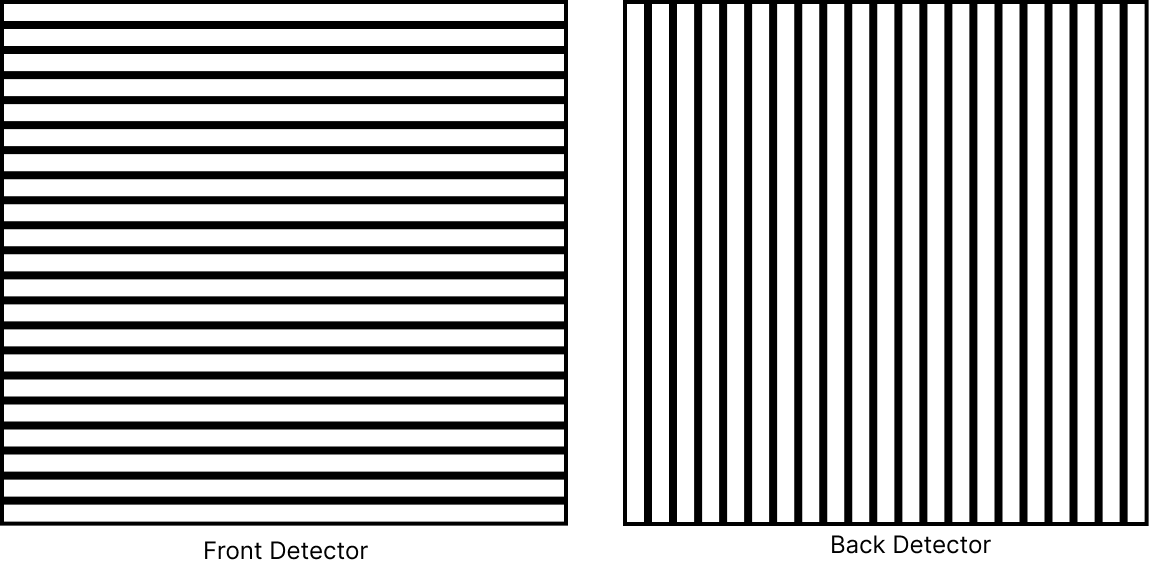

However, we don't need this exact setup to measure time of flight. For example, the GlueX forward TOF detector is positioned to detect particles that are launched in the forward direction (see the diagram below). For particles in the central region of the detector, timing information is provided by a detector called the barrel calorimeter (shown in yellow in the diagram below). The barrel calorimeter provides the "stop" time, and we can use the vertex time (the time the particle was created) as the start time.

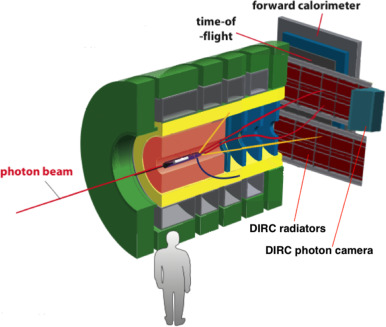

---
##**How Do We Use Time of Flight?**
---
Time of flight, when used with a measurement of momentum, can be used to find the mass of a particle. To see why, let's take a look at the definition of relativistic momentum:
$$
p=\frac{mv}{\sqrt{1-v^2/c^2}}
$$
If we multiply both sides by $\sqrt{1-v^2/c^2}$, we get
$$
p\sqrt{1-v^2/c^2} = mv
$$
Dividing both sides by $v$ gives us:$$
m = \frac{p\sqrt{1-v^2/c^2}}{v}
$$
If we have a measurement of both the momentum of the particle ($p$) and the velocity of the particle ($v$), we can plug these values into the equation above to solve for the mass of the particle, which we can use to identify the particle. In practice, we almost never calculate the mass directly. Instead, we create 2D histograms of $\beta$ (v/c) and momentum ($p$), which gives us more control over the cuts we make (we will talk about cuts later in this notebook).

####**Question #1a:**
---
By solving the definition of relativistic momentum for $v$, we get the following formula:
$$
v = \frac{p}{\sqrt{p^2/c^2 + m^2}}
$$
Letting $c=1$ (which we can do because all of the quantities are in proper units), we get:
$$
v = \frac{p}{\sqrt{p^2 + m^2}}
$$
Using this formula, what is the velocity of a proton with a momentum of 1 $GeV/c$? The mass of a proton is $0.938 GeV/c^2$. Use the cell below for any necessary calculations.

**Note:** The last line of code in the cell below will convert the velocity to meters per second. In this formula, the velocity is expressed as a fraction of the speed of light, which is common in special relativity.

In [ ]:
v = #Complete this code


#This next line of code will print out your answer and convert it to meters per second.
print("The velocity of the proton is " + str(round(v*3*10**8)) + " m/s.")

#####**Solution:**

Remember that in particle physics, almost all of the units are picked so that we can let $c=1$. Using this fact, the formula simplifies to:
$$
v = \frac{p}{\sqrt{p^2 + m^2}}
$$

In [ ]:
p = 1
m = 0.938
v = p/(p**2 + m**2)
#This next line of code will print out your answer and convert it to meters per second.
print("The velocity of the proton is " + str(round(v*3*10**8)) + " m/s.")

The velocity of the proton is 159587710 m/s.


The velocity of this proton is about 160,000,000 $m/s$, which is slightly over half the speed of light.

####**Question #1b:**
---
Using the same formula as before, what si the velocity of an electron with 1 $GeV/c$ of momentum? The mass of an electron is 0.000511 $GeV/c^2$. Use the cell below for any necessary computations.

In [ ]:
v = #Complete this code


#This next line of code will print out your answer and convert it to meters per second.
print("The velocity of the electron is " + str(round(v*3*10**8)) + " m/s.")

#####**Solution:**

In [ ]:
p = 1
m = 0.000511
v = p/(p**2 + m**2)

#This next line of code will print out your answer and convert it to meters per second.
print("The velocity of the electron is " + str(round(v*3*10**8)) + " m/s.")

The velocity of the electron is 299999922 m/s.


The velocity of this electron is almost 300,000,000 $m/s$. It is travelling at 99.99997% the speed of light!

####**Question #1c:**
---
A typical path length for a particle detected by the forward time of flight detector is $5.5$ meters. How long would it take a proton with 1 $GeV/c$ of momentum to travel this distance? How long would it take an electron with 1 $GeV/c$ of momentum to travel this distance? Use the cell below for any necessary computations.

**Hint:** Time of flight can be calculated as follows:
$$
t_{flight} = \frac{dx}{v}
$$ where $t_{flight}$ is the time of flight, $dx$ is the path length, and $v$ is the velocity of the particle. Use the velocities you calculated in Question #1a and #1b.

In [ ]:
proton_velocity =
electron_velocity =

t_flight_proton =
t_flight_electron =


print("The proton takes " + str(t_flight_proton) + "seconds to travel 5.5 meters.")
print("The electron takes " + str(t_flight_electron) + "seconds to travel 5.5 meters.")

#####**Solution:**

In [ ]:
proton_velocity = 159587710      #in units of m/s
electron_velocity = 299999922    # in units of m/s

path_length = 5.5                #in units of m

t_flight_proton = path_length/proton_velocity   #in units of s
t_flight_electron = path_length/electron_velocity #in units of s

print("The proton takes " + str(t_flight_proton) + " seconds to travel 5.5 meters.")
print("The electron takes " + str(t_flight_electron) + " seconds to travel 5.5 meters.")

The proton takes 3.4463806768077566e-08 seconds to travel 5.5 meters.
The electron takes 1.833333810000124e-08 seconds to travel 5.5 meters.


The "e-08" at the end of those numbers means $*10^{-8}$. In other words, the proton takes $3.45 * 10^{-8}$ seconds to travel 5.5 meters, while the electron takes $1.83 * 10^{-8}$ seconds to travel 5.5 meters.

####**Question #1d:**
---
A typical path length in the barrel calorimeter is about 1 meter. Using the velocities from Question #1a, complete the cell below to calculate the time of flight for 1 GeV proton and electron in the barrel calorimeter.

In [ ]:
proton_velocity =
electron_velocity =

t_flight_proton =
t_flight_electron =

print("The proton takes " + str(t_flight_proton) + "seconds to travel 1 meter.")
print("The electron takes " + str(t_flight_electron) + "seconds to travel 1 meter.")

#####**Solution:**

In [ ]:
proton_velocity = 159587710      #in units of m/s
electron_velocity = 299999922    #in units of m/s

path_length = 1                  #in units of m

t_flight_proton = path_length/proton_velocity
t_flight_electron = path_length/electron_velocity


print("The proton takes " + str(t_flight_proton) + " seconds to travel 1 meter.")
print("The electron takes " + str(t_flight_electron) + " seconds to travel 1 meter.")

The proton takes 6.266146685105012e-09 seconds to travel 5.5 meters.
The electron takes 3.333334200000225e-09 seconds to travel 5.5 meters.


Again, the "e-09" at the end of those numbers means $*10^{-9}$. In other words, the proton takes $6.3 * 10^{-9}$ seconds to travel 1 meter, while the electron takes $3.33* 10^{-9}$ seconds to travel 1 meter. These times are much shorter than they were in the previous part because the distance is so much shorter. The difference between these two times is much smaller as well, which would make these particles much harder to differentiate in the barrel calorimeter. In general, the larger the path length used for time of flight detectors, the better it is at identifying particles.

####**Question #1e:**
---
Based on your answers to Questions #1a, #1b, #1c, and #1d, why is it so important that time of flight detectors are able to make extremely accurate time measurements?

Double click to edit this cell and answer the following question: Why is it so important that time of flight detectors are able to make extremely accurate time measurements?

#####**Solution:**

Because the difference in time of flight of a proton and an electron at the same momentum is around $10^{-8}$ seconds, we need extremely accurate measurements of time to be able to detect this tiny difference. In fact, as we increase the momentum of the particles beyond 1 $GeV/c$, the difference in the time of flight between a proton and an electron only gets smaller.

---
##**Using the Forward TOF Detector**
---

To calculate the velocity of the particle, we can divide the distance travelled by the particle (the path length) by the time it took to travel that distance (the time of flight). Based on the vertex time and the "stop" time provided by the forward TOF detector, we can get an accurate measurement of the time of flight. Based on the vertex of the particle and the location of the hit in the TOF detector, we can measure the path length.

In this section, we will create a 2D histogram of the momentum of the particle ($p$) and the relativistic quantity $\beta$, which we will calculate based on time of flight and path length.

####**Question #2:**
---

In the cell below, create a canvas with the following properties using ROOT's TCanvas constructor:

*   Name: "c1"
*   Title: "Time of Flight Plot"
*   Width: 700
*   Height: 500

In [ ]:
canvas =

#####**Solution:**

In [ ]:
canvas = TCanvas("c1","Time of Flight Plot",700,500)

####**Question #3:**
---
In the cell below, create a 2D Histogram with the following properties using ROOT's TH2D constructor:

Write code in the cell below to create a histogram with the following properties:

*   Name: "h1"
*   Title: "Time of Flight Plot (Beta vs. Momentum)"
*   X axis label: "Momentum (GeV/c)"
*   Y axis label: "Beta"
*   Number of bins: 200 (both X and Y)
*   Minimum X value: 0
*   Maximum X value: 5
*   Minimum Y value: 0
*   Maximum Y value: 1.1

In [ ]:
h1 =

#####**Solution:**

In [ ]:
h1 = TH2D("h1","Time of Flight Plot (Beta vs. Momentum);Momentum (GeV/c);Beta",200,0,5,200,0,1.1)

####**Question #4a**
---
In the GlueX detector, distances are measured in centimeters, and times are measured in nanoseconds ($10^{-9}$ seconds). These units are convenient for storing the data from the detector, but are not useful for special relativity formulas. Therefore, in our relativistic formulas, we can no longer assume $c=1$.

To calculate $\beta$, the velocity we calculate $v$ must be in the same units as the speed of light $c$. Based on the fact that $v=dx/t_{flight}$, where $dx$ is the path length in centimeters and $t_{flight}$ is the time of flight in nanoseconds, what units should we use for $c$? What is the value of the speed of light in these units?

**Hint:** Use Google to find the speed of light in the units you choose, and round to the nearest whole number.

Double click to edit this cell and answer the following question: What units should we use for $c$? What is the value of the speed of light in these units?

#####**Solution:**

Because the path length is in centimeters and the time of flight is in nanoseconds, when we plug our values into the equation $$
v = \frac{dx}{t_{flight}},
$$ we will get a velocity in units of centimeters per nanosecond. When you Google the speed of light in centimeters per nanosecond (cm/ns), you get a value of about $29.9$, but we can round this up to $c=30$ cm/ns.

####**Question #4b:**
---
Complete the loop in the cell below to use the Fill method of the TH2D object to fill in the histogram with the momenta and $\beta$ values based on the data stored in the dataframe called `TOF_hits`. The momentum is in the column labeled `p`, the path length is found in the column labeled `dx`, and the time of flight is found in the column labeled `TOF`.

**Hint:** Remember that the path lengths are in centimeters and the time of flight is in nanoseconds when calculating $\beta$.

In [ ]:
for row in #Complete this code
  #Complete this code
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

#####**Solution:**

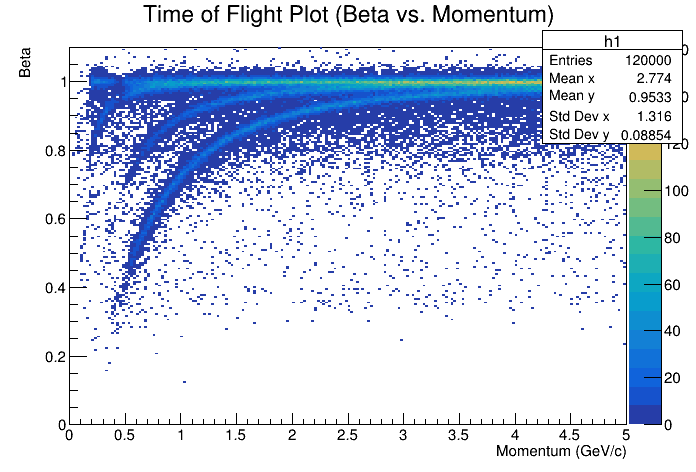

In [ ]:
for row in TOF_hits.iloc:
  v = row['dx']/row['TOF']
  beta = v/30              #We divide v by the speed of light in cm/ns
  h1.Fill(row['p'], beta)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

####**Question #5:**
---

You can also save canvases! In Google Colab, you can just right click and select "Save Image as". However, in many other situations, it is useful to save an image in your code. Lucky for us, ROOT's TCanvas class has a `SaveAs` method, which allows us to save an image. The syntax is as follows:
```
canvas.SaveAs("filename.png")
```

In the cell below, use the TH2D's `SetStats` method to remove the statistics box from the plot. Then, use TCanvas's `SaveAs` method to save your plot as "tofPlot.png".

#####**Solution:**

In [ ]:
h1.SetStats(0)
canvas.SaveAs("tofPlot.png")

Info in <TCanvas::Print>: png file tofPlot.png has been created


**Note:** To check that your solution worked, you can click the folder icon shown to the left, which should show you all of the files that are saved on the remote computer that this notebook is running on. You should see a file in the menu called "tofPlot.png". If you'd like, you can right click the file and select "Download" to download the image to your computer. Otherwise, the file will be deleted when you close out of the notebook (files are not saved in Google Colab, but the code is saved, so you can come back and recreate the image at any time!)

---
##**Using the Barrel Calorimeter**
---

To calculate the velocity of the particle, we can divide the distance travelled by the particle (the path length) by the time it took to travel that distance (the time of flight). Based on the vertex time and the "stop" time provided by the forward TOF detector, we can get an accurate measurement of the time of flight. Based on the vertex of the particle and the location of the hit in the TOF detector, we can measure the path length.

In this section, we will create a 2D histogram of the momentum of the particle ($p$) and the relativistic quantity $\beta$, which we will calculate based on time of flight and path length.

####**Question #6:**
---

In the cell below, complete the code to create a 2D histogram of momentum and $\beta$ using data from the `BCal_TOF_hits` dataframe. The path length is stored in the column `dx BCal` and the time of flight is stored in the `tShower` column. The momentum can still be found in the `p` column.

**Note:** The properties of the canvas and histogram can be copied from the previous part.

In [ ]:
canvas =
h1 =
for row in #Complete this code
  #Complete this code
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

#####**Solution:**

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


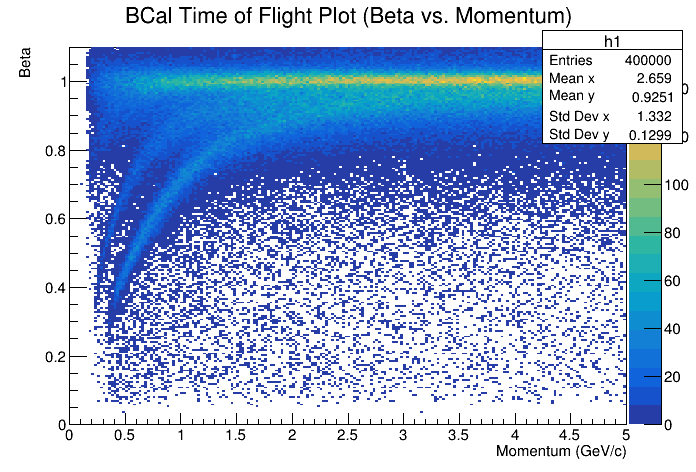

In [ ]:
canvas = TCanvas("c1","Time of Flight Plot",700,500)
h1 = TH2D("h1","BCal Time of Flight Plot (Beta vs. Momentum);Momentum (GeV/c);Beta",200,0,5,200,0,1.1)
for row in BCal_TOF_hits.iloc:
  v = row['dx BCal']/row['tShower']
  beta = v/30              #We divide v by the speed of light in cm/ns
  h1.Fill(row['p'], beta)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

####**Question #7:**
---
The code shown below generates two plots. The first is created from measurements of the TOF detector, while the other is created using measurements of the barrel calorimeter (BCal). What do you notice about these two plots?

Double click to edit this cell and answer the following question: What do you notice about these two plots?

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


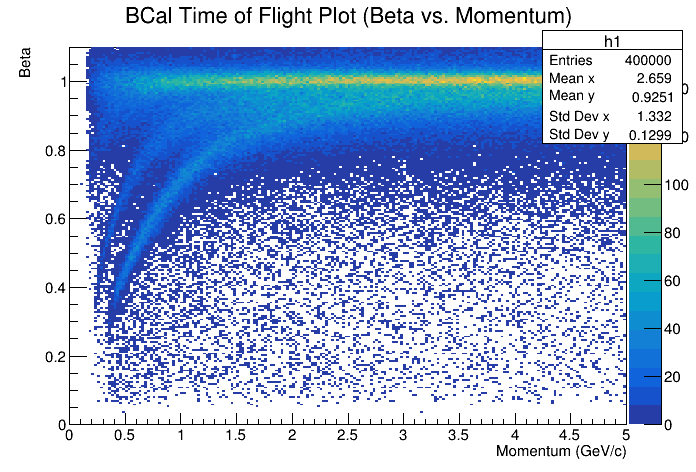

In [ ]:
#@title #####**BCal Plot**
canvas = TCanvas("c1","Time of Flight Plot",700,500)
h1 = TH2D("h1","BCal Time of Flight Plot (Beta vs. Momentum);Momentum (GeV/c);Beta",200,0,5,200,0,1.1)
for row in BCal_TOF_hits.iloc:
  v = row['dx BCal']/row['tShower']
  beta = v/30              #We divide v by the speed of light in cm/ns
  h1.Fill(row['p'], beta)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


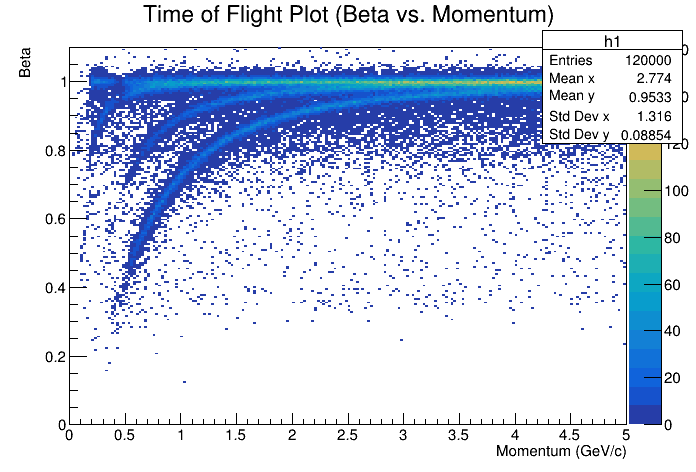

In [ ]:
#@title #####**TOF Plot**
canvas = TCanvas("c1","Time of Flight Plot",700,500)
h1 = TH2D("h1","Time of Flight Plot (Beta vs. Momentum);Momentum (GeV/c);Beta",200,0,5,200,0,1.1)
for row in TOF_hits.iloc:
  v = row['dx']/row['TOF']
  beta = v/30              #We divide v by the speed of light in cm/ns
  h1.Fill(row['p'], beta)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

#####**Solution:**

Both of the plots have "stripes" that represent different particles. However, the stripes in the plot made from the barrel calorimeter times are significantly wider.

As we saw in the "2D Histograms in ROOT" activity, a more "blurry" histogram is associated with more statistical fluctuations or experimental error. In Question #1d, we saw that the shorter path length in the barrel calorimeter makes the difference in time of flight between a 1 GeV proton and a 1 GeV electron much shorter.

This shorter time is harder to detect, meaning the barrel calorimeter may falsely measure that a 1 GeV proton and a 1 GeV electron have the same time of flight. This leads to an inaccurate measurement of the velocity of these two particles, which is the main source of the blurriness in the barrel calorimeter plot.

####**Question #8:**
---
Although this isn't typically done in practice, we could use the value of $\beta$ that we measure along with the momentum to calculate the invariant mass of the particle. By solving the definition of relativistic momentum for the mass $m$, we get:
$$
m = \frac{p\sqrt{1-v^2/c^2}}{v}
$$
If we let $c=1$, then $\beta = v/c = v/1=v$, so we can write: $$
m = \frac{p\sqrt{1-\beta^2}}{\beta}
$$

Complete the code in the cell below to create a 1D histogram with the masses of particles calculated from their time of flight.

In [ ]:
canvas = TCanvas("c1","Time of Flight Masses",700,500)
h1 = TH1D("h1","Masses of Charged Particles from TOF;Mass (GeV/c^2);Counts",200,0,1)
for row in TOF_hits.iloc:
  v = row['dx']/row['TOF']
  beta = v/30              #We divide v by the speed of light in cm/ns
  m = #Complete this code
  h1.Fill(m)
h1.Draw()
gROOT.GetListOfCanvases().Draw()

#####**Solution:**

<ipython-input-17-3f341d856449>:6: RuntimeWarning: invalid value encountered in double_scalars
  m = row['p']*(1-beta**2)**0.5/beta
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


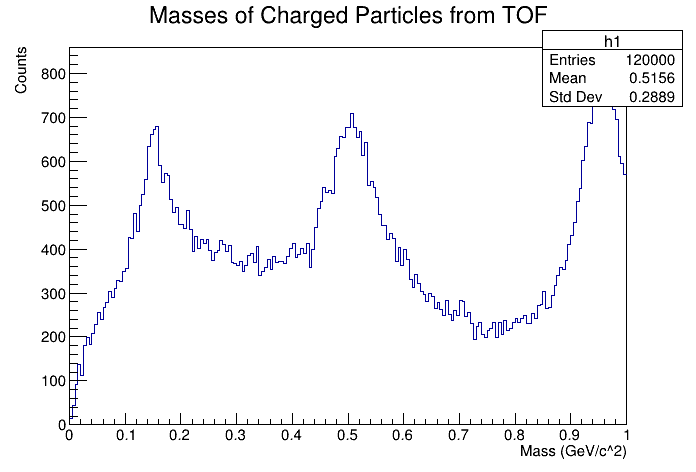

In [ ]:
canvas = TCanvas("c1","Time of Flight Masses",700,500)
h1 = TH1D("h1","Masses of Charged Particles from TOF;Mass (GeV/c^2);Counts",200,0,1)
for row in TOF_hits.iloc:
  v = row['dx']/row['TOF']
  beta = v/30              #We divide v by the speed of light in cm/ns
  m = row['p']*(1-beta**2)**0.5/beta
  h1.Fill(m)
h1.Draw()
gROOT.GetListOfCanvases().Draw()

The histogram of invariant masses show spikes around the masses of the stable particles we detect! The spike between 0.1 and 0.2 GeV/c^2 corresponds to the pion, the spike near 0.5 GeV/c^2 corresponds to the kaon, and the spike between 0.9 and 1 GeV/c^2 corresponds to the proton/antiproton.

Although we could make plots like this and use them to classify particles, it is far more common to make other kinds of cuts that are simpler and require less computation.

---
##**Making Cuts**
---
In order to use TOF as a classification tool, we use **cuts**. Cuts are conditions that we use to make restrictions on our data. In many cases, our cuts take the form of inequalities. For example, we may say that if the mass of a particle is greater than 0.7 GeV/c^2, then it is a Proton. The corresponding cut would be $m>0.7$, where $m$ is the mass of the particle.

Although plots of momentum and $\beta$ are extremely useful for visualizing the ability to distinguish particles using time of flight, it is not the easiest way to make cuts. Typically, we make cuts directly on the time of flight. Based on the path length $dx$ and the momentum $p$, we can calculate how long each type of particle should take to travel that distance.

For example, if we detect a particle with a momentum of 1 GeV/c and its path length is 5.5 meters, we could calculate how long it would take a proton to travel that distance, a kaon to travel that distance, a pion etc. We can then compare the measured time of flight to each of these calculated values, and if the measured time of flight is close enough to one of the calculated values, we can identify the particle using that time.

####**Question #9:**
---
By solving the definition of relativistic momentum for the velocity, we get the following formula: $$
v = \frac{p}{\sqrt{p^2 + m^2}}
$$ Furthermore, we can solve $dx = v*t_{flight}$ for the time of flight to get $$
t_{flight} = \frac{dx}{v}
$$
Combining these two equations, we get: $$
t_{flight} = \frac{dx \sqrt{p^2 + m^2}}{p}
$$

Complete the code below to create functions that calculate the time of flight for protons, kaons, pions, and electrons based on the momentum and path length. The masses of these particles are:

| <h5>**Particle** 	| <h5>**Mass (GeV/c^2)** 	|
|---------:	|:--------------:	|
|   <h5>Proton 	|      <h5>0.938     	|
|     <h5>Kaon 	|      <h5>0.494     	|
|     <h5>Pion 	|      <h5>0.14      	|
| <h5>Electron 	|    <h5>0.000511    	|

**Note:** In the return statement, we divide by $30$ to convert from relativistic units into nanoseconds. You don't need to change that line of the function.

In [ ]:
def proton_time(path_length, momentum):
  TOF = #Complete this code
  return TOF/ 30

def kaon_time(path_length, momentum):
  TOF = #Complete this code
  return TOF/ 30

def pion_time(path_length, momentum):
  TOF = #Complete this code
  return TOF/ 30

def electron_time(path_length, momentum):
  TOF = #Complete this code
  return TOF/ 30

#####**Solution:**

In [ ]:
def proton_time(path_length, momentum):
  TOF = path_length * (momentum**2+0.938**2)**0.5/momentum
  return TOF/ 30

def kaon_time(path_length, momentum):
  TOF = path_length * (momentum**2+0.494**2)**0.5/momentum
  return TOF/ 30

def pion_time(path_length, momentum):
  TOF = path_length * (momentum**2+0.14**2)**0.5/momentum
  return TOF/ 30

def electron_time(path_length, momentum):
  TOF = path_length * (momentum**2+0.000511**2)**0.5/momentum
  return TOF/ 30

####**Question #10:**
---
Based on how accurate we need our particle identification to be, we can require the measured time of flight to be closer to the calculated times. Typically, kaons are the hardest particle to identify because they decay into pions and electrons, so it is not uncommon to place strict cuts on kaons. For time of flight calculations, the cuts we make look like: $$
|t_{flight}-t_{calculated}|\leq \Delta t
$$
where $t_{flight}$ is the measured time of flight, $t_{calculated}$ is the calculated time of flight for the given particle, and $\Delta t$ is the allowed difference in times. Making $\Delta t$ smaller makes our identifications more accurate, but reduces the number of particles we are able to identify.

Based on the values for $\Delta t$ in the table below, complete the code in the cell below to classify particles using time of flight.

| <h5>**Particle** </h5> 	| <h5>**$\Delta t$ (nanoseconds)**</h5>	|
|---------:	|:------------------------:	|
|   <h5>Proton</h5> 	|    <h5>$0.6$</h5>   	|
|     <h5>Kaon</h5> 	|    <h5>$0.3$</h5>   	|
|     <h5>Pion</h5> 	|    <h5>$0.5$</h5>   	|
| <h5>Electron</h5> 	|    <h5>$0.5$</h5>   	|

**Hint:** Use the functions you defined in Question #9 to calculate the time of flight in nanoseconds!

In [ ]:
def identify_particle(time_of_flight, path_length, momentum):
  if #Complete this code
    return "Proton"
  elif #Complete this code
    return "Kaon"
  elif #Complete this code
    return "Pion"
  elif #Complete this code
    return "Electron"
  else:
    return "Unknown"

#####**Solution:**

The value of $t_{calculated}$ is given to us by the functions we created in Question #9. To get the value on the other side of the inequality, we need to read the matching value of $\Delta t$ from the table.

In [ ]:
def identify_particle(time_of_flight, path_length, momentum):
  if abs(proton_time(path_length,momentum)-time_of_flight) <= 0.6:
    return "Proton"
  elif abs(kaon_time(path_length,momentum)-time_of_flight) <= 0.3:
    return "Kaon"
  elif abs(pion_time(path_length,momentum)-time_of_flight) <= 0.5:
    return "Pion"
  elif abs(electron_time(path_length,momentum)-time_of_flight) <= 0.5:
    return "Electron"
  else:
    return "Unknown"

####**Question #11:**
---
Run the cell below to create a 2D histogram of all of the particles we can identify using our time of flight function. What do you notice when you compare this histogram to the histogram created in Question #4b?

Double click to edit this cell and answer the following question: What do you notice when you compare this histogram to the histogram created in Question #4b?

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


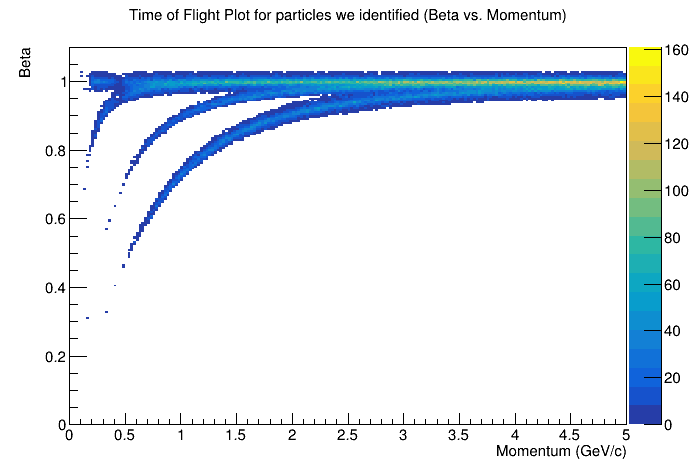

In [ ]:
# @title
canvas = TCanvas("c1","Time of Flight Plot",700,500)
h1 = TH2D("h1","Time of Flight Plot for particles we identified (Beta vs. Momentum);Momentum (GeV/c);Beta",200,0,5,200,0,1.1)
for row in TOF_hits.iloc:
  v = row['dx']/row['TOF']
  beta = v/30              #We divide v by the speed of light in cm/ns
  if identify_particle(row['TOF'],row['dx'],row['p']) != "Unknown":
    h1.Fill(row['p'], beta)
h1.SetStats(0)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

#####**Solution:**

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


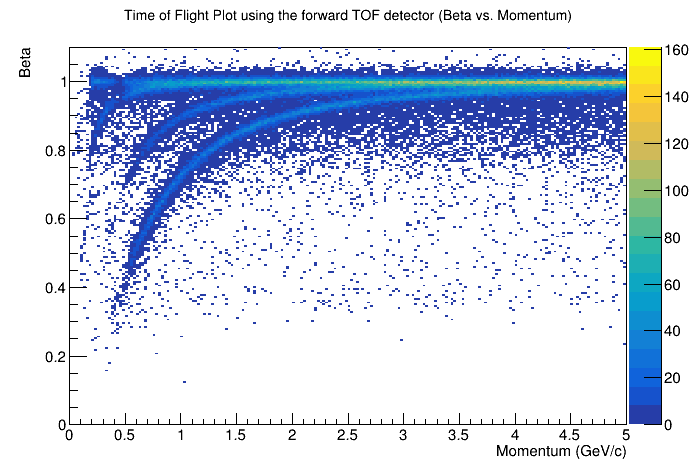

In [ ]:
# @title The histogram from Question #4b:
canvas = TCanvas("c1","Time of Flight Plot",700,500)
h1 = TH2D("h1","Time of Flight Plot using the forward TOF detector (Beta vs. Momentum);Momentum (GeV/c);Beta",200,0,5,200,0,1.1)
for row in TOF_hits.iloc:
  v = row['dx']/row['TOF']
  beta = v/30              #We divide v by the speed of light in cm/ns
  h1.Fill(row['p'], beta)
h1.SetStats(0)
h1.Draw('COLZ')
gROOT.GetListOfCanvases().Draw()

Comparing the two histograms, the histogram created from the particles we identified only shows the distinct stripes in the histogram, and all of the points that are far away from these lines are classified as "unknown" according to this method. However, other PID methods may be able to identify these particles, even if TOF wasn't able to.